In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import stan
import nest_asyncio
from mpl_toolkits.mplot3d import Axes3D
nest_asyncio.apply()
import time

In [141]:
# Parámetros de las distribuciones
alpha = 6
beta_param = 1.7
mu = 0.4
sigma = 0.1
p = 0.33  # Probabilidad de elegir la componente "b"
seed = 3
N = 1000

def create_data_4d(alpha, beta_param, mu, sigma, p, seed, n=N):
    np.random.seed(seed)  # Fijamos la semilla para reproducibilidad

    # Inicializamos listas para los datos de cada columna
    out_s1, out_s2, out_s3, out_s4 = [], [], [], []
    classes = []  # Para almacenar las clases

    # Generamos una matriz de decisiones Bernoulli (1 o 0) de tamaño (n, 4) para los 4 scores
    bernoulli = np.random.binomial(1, p, size=(n * 3, 4))  # Multiplicamos por 3 para tener suficientes válidos

    # Filtramos solo las combinaciones válidas  (VIENEN DE A PARES, jjjj, bbjj, bbbb, tanto b como j)
    valid_combinations = [row for row in bernoulli if np.sum(row) in [0, 2, 4]]

    # Tomamos solo las primeras 'n' combinaciones válidas
    valid_combinations = np.array(valid_combinations[:n])

    # Iteramos sobre cada fila (cada observación) de las combinaciones válidas
    for i in range(n):
        # Para cada score (s1, s2, s3, s4), decidimos si será de la componente Beta (b) o Normal (j)
        out_s1.append(beta.rvs(alpha, beta_param) if valid_combinations[i, 0] == 1 else np.random.normal(mu, sigma))
        out_s2.append(beta.rvs(alpha, beta_param) if valid_combinations[i, 1] == 1 else np.random.normal(mu, sigma))
        out_s3.append(beta.rvs(alpha, beta_param) if valid_combinations[i, 2] == 1 else np.random.normal(mu, sigma))
        out_s4.append(beta.rvs(alpha, beta_param) if valid_combinations[i, 3] == 1 else np.random.normal(mu, sigma))

        # Definir la clase según la combinación de componentes
        if np.all(valid_combinations[i] == 1):  # Todos son Beta
            classes.append('bbbb')
        elif np.all(valid_combinations[i] == 0):  # Todos son Normal
            classes.append('jjjj')
        else:  # Exactamente dos son Beta y dos son Normal
            classes.append('bbjj')

    return np.array(out_s1), np.array(out_s2), np.array(out_s3), np.array(out_s4), np.array(classes)

# Crear los datos
s1, s2, s3, s4, classes = create_data_4d(alpha, beta_param, mu, sigma, p, seed)

# Visualizar los datos generados
data = pd.DataFrame({'s1': s1, 's2': s2, 's3': s3, 's4': s4, 'class': classes})
print(data.head())
print(data['class'].value_counts())
print(len(data))

         s1        s2        s3        s4 class
0  0.891149  0.699934  0.427209  0.319293  bbjj
1  0.311800  0.410846  0.357306  0.110520  jjjj
2  0.375852  0.261075  0.409295  0.373729  jjjj
3  0.871191  0.769440  0.315146  0.295990  bbjj
4  0.434892  0.381998  0.317097  0.425917  jjjj
class
bbjj    587
jjjj    391
bbbb     22
Name: count, dtype: int64
1000


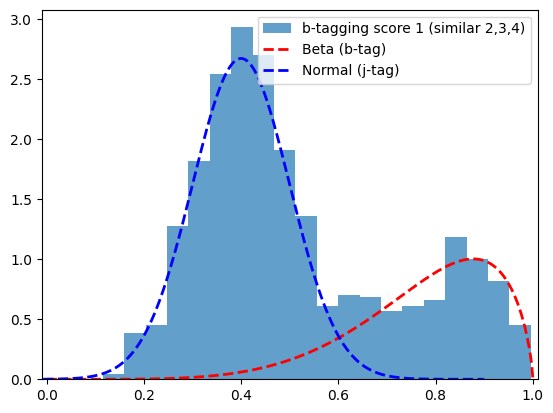

In [142]:
plt.hist(data['s1'], bins=20, alpha=0.7, label='b-tagging score 1 (similar 2,3,4)', density=True)
#plt.hist(data['s2'], bins=20, alpha=0.7, label='b-tagging score 2', density=True)

# Curvas teóricas de la distribución Beta ponderada
x_beta = np.linspace(0, 1, 500)  # Valores para la curva Beta
beta_pdf = (p) * beta.pdf(x_beta, alpha, beta_param)  # Densidad de probabilidad de la Beta ponderada
plt.plot(x_beta, beta_pdf, 'r--', lw=2, label='Beta (b-tag)')

# Curvas teóricas de la distribución Normal ponderada
x_normal = np.linspace(-0.1, 0.9, 500)  # Valores para la curva Normal
normal_pdf = (1-p) * norm.pdf(x_normal, mu, sigma)  # Densidad de probabilidad de la Normal ponderada
plt.plot(x_normal, normal_pdf, 'b--', lw=2, label='Normal (j-tag)')

# Mostrar leyenda y gráfico
plt.xlim(-0.01,1.01)
plt.legend()
plt.show()


In [143]:
# Reescalar los scores al intervalo [1, m] y convertir a enteros
m = 20
def rescale_to_interval(values, m):
    return np.round(values * (m - 1) + 1).astype(int)

s1_rescaled = rescale_to_interval(s1, m)
s2_rescaled = rescale_to_interval(s2, m)
s3_rescaled = rescale_to_interval(s3, m)
s4_rescaled = rescale_to_interval(s4, m)

# Crear un nuevo DataFrame con los valores reescalados
rescaled_data = pd.DataFrame({
    's1': s1_rescaled,
    's2': s2_rescaled,
    's3': s3_rescaled,
    's4': s4_rescaled,
    'class': classes
})

print(rescaled_data.head())
print(rescaled_data['class'].value_counts())
print(len(rescaled_data))

   s1  s2  s3  s4 class
0  18  14   9   7  bbjj
1   7   9   8   3  jjjj
2   8   6   9   8  jjjj
3  18  16   7   7  bbjj
4   9   8   7   9  jjjj
class
bbjj    587
jjjj    391
bbbb     22
Name: count, dtype: int64
1000


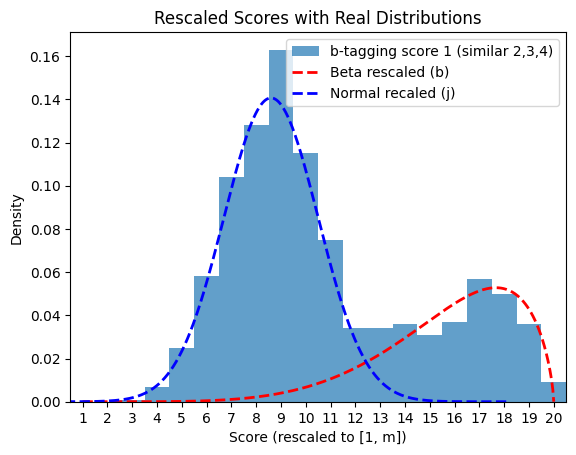

In [144]:
# Definición de la función para reescalar los puntos de soporte de la distribución
def rescale_distribution(x, m):
    return x * (m - 1) + 1

# Reescalar las distribuciones teóricas al intervalo [1, m]
x_beta_rescaled = rescale_distribution(np.linspace(0, 1, 500), m)  # Puntos de soporte reescalados para la Beta
beta_pdf_rescaled = (p) * beta.pdf((x_beta_rescaled - 1) / (m - 1), alpha, beta_param) / (m - 1)  # PDF Beta ponderada reescalada

x_normal_rescaled = rescale_distribution(np.linspace(-0.1, 0.9, 500), m)  # Puntos de soporte reescalados para la Normal
normal_pdf_rescaled = (1-p) * norm.pdf((x_normal_rescaled - 1) / (m - 1), mu, sigma) / (m - 1)  # PDF Normal ponderada reescalada

# Graficar los histogramas de los datos reescalados
plt.hist(rescaled_data['s1'], bins=np.arange(1, m + 2) - 0.5, alpha=0.7, label='b-tagging score 1 (similar 2,3,4)', density=True)

# Graficar las curvas teóricas ponderadas reescaladas
plt.plot(x_beta_rescaled, beta_pdf_rescaled, 'r--', lw=2, label='Beta rescaled (b) ')
plt.plot(x_normal_rescaled, normal_pdf_rescaled, 'b--', lw=2, label='Normal recaled (j)')

# Mostrar leyenda y gráfico
plt.xlim(1-0.5,m+0.5)
plt.xticks(np.arange(1,m+1))
plt.legend()
plt.xlabel('Score (rescaled to [1, m])')
plt.ylabel('Density')
plt.title('Rescaled Scores with Real Distributions')
plt.show()

In [145]:
rescaled_data

,s1,s2,s3,s4,class
0,18,14,9,7,bbjj
1,7,9,8,3,jjjj
2,8,6,9,8,jjjj
3,18,16,7,7,bbjj
4,9,8,7,9,jjjj
...,...,...,...,...,...
995,8,9,10,10,jjjj
996,7,8,7,8,jjjj
997,17,13,8,17,bbjj
998,17,9,16,11,bbjj


In [146]:
score = rescaled_data[['s1', 's2', 's3', 's4']].values.tolist()
print(score[:3])
print(len(score))


[[18, 14, 9, 7], [7, 9, 8, 3], [8, 6, 9, 8]]
1000


In [147]:
my_mixture_4d = """
functions {
  real partial_sum(array[,] int score_slice,
                   int start, int end,
                   vector yj,
                   vector yb,
                   vector theta)
{
    real permutation_factor = 1.0/6;
    real partial_target = 0;
    
    vector[3] lp;   //3 clases distintas: fondo jjjj y bbjj (+perm) y señal bbbb.
    vector[6] lp2;  //para que sea más cómodo la clase con permutaciones.
    
    int slice_length = end - start + 1;

    for (k in 1:slice_length) {
     lp2[1] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[2] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[3] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
     lp2[4] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[5] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
     lp2[6] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yj)[score_slice[k,4]];

     lp[1] = log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yj)[score_slice[k,4]]; // esto es jjjj.
     lp[2] = log_sum_exp(lp2);    //esto es bbjj + perm.
     lp[3] = log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]]; //esto es bbbb.

     partial_target += log_mix(theta, lp);
     }

    return partial_target;
  }
}

data {
  int<lower=1> m;  // steps in the discretization
  int<lower=1> N;  // data points
  array[N,4] int<lower=1, upper=m> score;  // b-tagging score for jet#1
}

parameters {
  simplex[3] theta;  // Mixture coefficients of 3 classes as a simplex
  
  simplex[m] w_j_mode;  // Dirichlet weights for the background jjjj (and bbjj?)
  vector<lower=0>[m-1] a_j;  // Normal parameters for the background
  
  simplex[m] w_b_mode;  // Dirichlet weights for the signal bbbb
  vector<lower=0>[m-1] a_b;  // Normal parameters for the signal
}

transformed parameters {
  ordered[2] y_label_switch_1; 
  ordered[2] y_label_switch_2;

  vector[m] p_j;  // Approximate distribution for the background
  vector[m-1] sign_j;  // Signs for combination
  vector[m] logp_j;  // Log-probabilities
  
  sign_j = rep_vector(-1.0, m-1);
  p_j = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_j[j] = 1.0;
      }
    }
    logp_j[1] = 0.0;
    for (j in 2:m) {
      logp_j[j] = logp_j[j-1] + sign_j[j-1] * a_j[j-1];
    }
    p_j += softmax(logp_j) * w_j_mode[k];
  }

  vector[m] p_b;  // Approximate distribution for the signal
  vector[m-1] sign_b;  // Signs for combination
  vector[m] logp_b;  // Log-probabilities

  sign_b = rep_vector(-1.0, m-1);
  p_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p_b += softmax(logp_b) * w_b_mode[k];
  }
  y_label_switch_1[1] = p_b[8];
  y_label_switch_1[2] = p_j[8];

  y_label_switch_2[1] = p_j[16];
  y_label_switch_2[2] = p_b[16];

}

model {
  int grainsize = 1;  // Adjust for parallel performance
  
  theta ~ dirichlet(rep_vector(1.0, 3));
  
  a_j ~ normal(0, 0.5);
  a_b ~ normal(0, 0.5);

  w_b_mode ~ dirichlet(rep_vector(1.0, m));
  w_j_mode ~ dirichlet(rep_vector(1.0, m));

  target += reduce_sum(partial_sum, score, grainsize, p_j, p_b, theta);
}


"""

In [148]:
# Start the timer
start_time_4d = time.time()

# Build and sample from the 2D mixture model
model_4d = stan.build(my_mixture_4d, data={'m': m, 'N': len(score), 'score':score}, random_seed=33)
fit_4d = model_4d.sample(num_chains=2, num_samples=500)
df_4d = fit_4d.to_frame()

# Stop the timer
end_time_4d = time.time()

# Calculate the elapsed time
elapsed_time_4d = end_time_4d - start_time_4d

# Print the elapsed time
print(f"Time taken to run the 2D model: {elapsed_time_4d:.2f} seconds")


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_mohqe494/model_jvs3xzto.stan', line 114, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Sampling:   0%
Sampling:   3% (100/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1601/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1801/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  73% (2201/3000)
Sampling:  77% (2301/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
S

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0476623, but should be greater than the previous element, 0.0477475 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0465934, but should be greater than

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.044326, but should be greater than the previous element, 0.0458081 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0440272, but should be greater than the previous element, 0.0441856 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to colu

  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0404142, but should be greater than the previous element, 0.0412258 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0420306, but should be greater than the previous element, 0.0439846 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0464562, but should be greater than the previous element, 0.0466793 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mode

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0453281, but should be greater than the previous element, 0.0454866 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0458596, but should be greater than

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.127493, but should be greater than the previous element, 0.127631 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 53, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.128271, but should be greater than the previous element, 0.128642 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 53, column 2 to column 

  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0398325, but should be greater than the previous element, 0.0407021 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0432345, but should be greater than the previous element, 0.0449344 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0421325, but should be greater than the previous element, 0.0424279 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mode

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0670676, but should be greater than the previous element, 0.0793294 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 53, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0100241, but should be greater than the previous element, 0.117236 (in '/tmp/httpstan_bx9il4t2/model_jvs3xzto.stan', line 53, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jvs3xzto_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0161094, but should be greater than the previou

Time taken to run the 2D model: 42.62 seconds


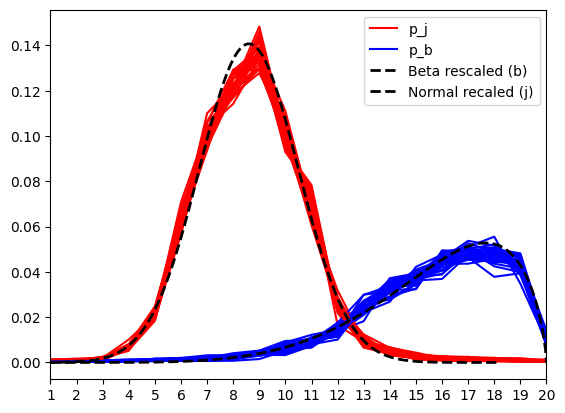

In [149]:
#Normalizing and plotting inferred distributions
for i in range(30):
    # Extract the p_j and p_b values for the current sample
    p_j_values = np.array([df_4d.iloc[i]['p_j.' + str(x)] for x in range(1, 21)])
    p_b_values = np.array([df_4d.iloc[i]['p_b.' + str(x)] for x in range(1, 21)])
    # Normalize the values
    p_j_values_normalized = p_j_values / p_j_values.sum()
    p_b_values_normalized = p_b_values / p_b_values.sum()
    
    # Plot the normalized curves
    if i == 0:
        plt.plot(range(1, 21), (1-p)*p_j_values_normalized, color='red', label='p_j')
        plt.plot(range(1, 21), (p)*p_b_values_normalized, color='blue', label='p_b')

    else:
        plt.plot(range(1, 21), (1-p)*p_j_values_normalized, color='red')
        plt.plot(range(1, 21), (p)*p_b_values_normalized, color='blue')


# Graficar las curvas teóricas ponderadas reescaladas
plt.plot(x_beta_rescaled, beta_pdf_rescaled, '--',color='black', lw=2, label='Beta rescaled (b) ')
plt.plot(x_normal_rescaled, normal_pdf_rescaled, '--',color='black', lw=2, label='Normal recaled (j)')

#plt.hist(rescaled_data['s1'],bins=np.arange(1,m+2)-0.5,density=True,label='Real data')

plt.xticks(np.arange(1,m+1))
plt.xlim(1,m)
plt.legend()
#plt.grid(alpha=0.5)
plt.show()

fraction of bbjj: 0.587
fraction of jjjj: 0.391
fraction of bbbb: 0.022


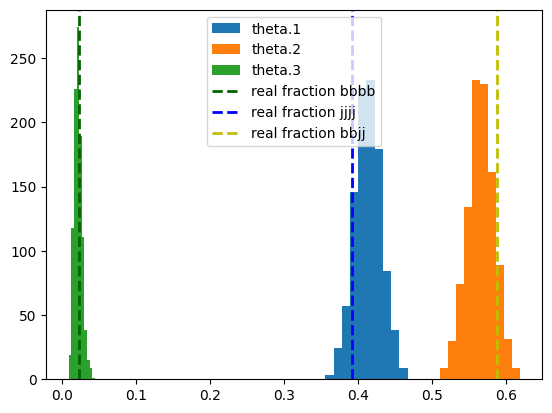

In [202]:
plt.hist(df_4d['theta.1'], label = 'theta.1')
plt.hist(df_4d['theta.2'], label = 'theta.2')
plt.hist(df_4d['theta.3'], label = 'theta.3')


# Calcular y imprimir las fracciones reales de cada clase
fraction_bbjj = data['class'].value_counts()['bbjj'] / N
fraction_jjjj = data['class'].value_counts()['jjjj'] / N
fraction_bbbb = data['class'].value_counts()['bbbb'] / N
print('fraction of bbjj:', fraction_bbjj)
print('fraction of jjjj:', fraction_jjjj)
print('fraction of bbbb:', fraction_bbbb)

plt.axvline(fraction_bbbb,ls='--',color='darkgreen',lw=2,label='real fraction bbbb')
plt.axvline(fraction_jjjj,ls='--',color='b',lw=2,label='real fraction jjjj')
plt.axvline(fraction_bbjj,ls='--',color='y',lw=2,label='real fraction bbjj')


plt.legend()
plt.show()

In [153]:
import ternary

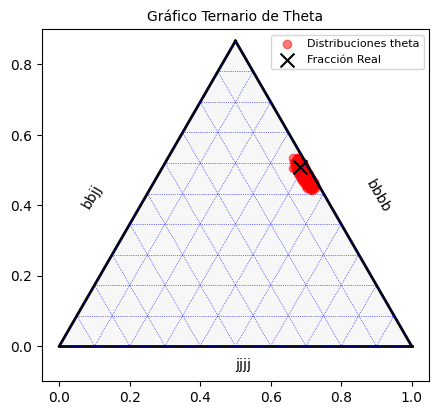

In [220]:
theta1 = df_4d['theta.1']  # Se asocia a una clase
theta2 = df_4d['theta.2']
theta3 = df_4d['theta.3']

# Calcular las fracciones reales de cada clase
real_fractions = {
    'bbjj': fraction_bbjj,
    'jjjj': fraction_jjjj,
    'bbbb': fraction_bbbb
}

# Configurar el tamaño de la figura
scale = 1.0  # Escala del gráfico ternario
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

# Crear el gráfico ternario
figure, tax = ternary.figure(ax=ax, scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=0.1)

# Agregar los puntos de theta al gráfico ternario
points = list(zip(theta1, theta2, theta3))
tax.scatter(points, marker='o', color='red', alpha=0.5, label="Distribuciones theta")

# Coordenadas de la fracción real en el gráfico ternario
real_fraction_coords = (real_fractions['jjjj'], real_fractions['bbjj'], real_fractions['bbbb'])

# Agregar una cruz en el gráfico para la fracción real
tax.scatter([real_fraction_coords], marker='x', color='black', s=100, label="Fracción Real")

# Etiquetas y ajustes basados en las fracciones reales
tax.left_axis_label("bbjj", fontsize=10, offset=0.16)
tax.right_axis_label("bbbb", fontsize=10, offset=0.16)
tax.bottom_axis_label("jjjj", fontsize=10, offset=-0.08)
tax.set_title("Gráfico Ternario de Theta", fontsize=10)
tax.legend(fontsize=8)

# Mostrar el gráfico
tax.show()

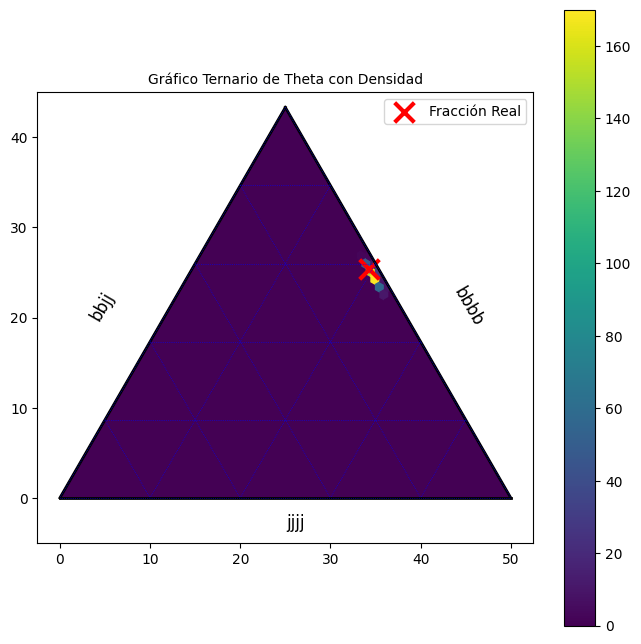

In [251]:
# Extraer los valores de theta del dataframe
theta1 = df_4d['theta.1']
theta2 = df_4d['theta.2']
theta3 = df_4d['theta.3']

# Calcular las fracciones reales de cada clase
real_fractions = {
    'bbjj': fraction_bbjj,
    'jjjj': fraction_jjjj,
    'bbbb': fraction_bbbb
}

# Configurar el tamaño de la figura
scale = 50  # Ajustar el scale según el número de puntos
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Crear el gráfico ternario
figure, tax = ternary.figure(ax=ax, scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=10)  # Ajustar el multiple según el scale

# Crear los puntos para el gráfico ternario
points = np.array(list(zip(theta1, theta2, theta3)))

# Crear el histograma de densidad
hist, edges = np.histogramdd(points, bins=[scale+1, scale+1, scale+1], range=[[0, 1], [0, 1], [0, 1]])

# Convertir el histograma a un diccionario para la función heatmap
heatmap_data = {}
for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        k = scale - i - j
        if k >= 0:
            heatmap_data[(i, j)] = hist[i, j, k]

# Dibujar el heatmap en el gráfico ternario
tax.heatmap(heatmap_data, scale=scale, style="hexagonal", cmap='viridis')

# Coordenadas de la fracción real en el gráfico ternario
real_fraction_coords = (real_fractions['jjjj'] * scale, real_fractions['bbjj'] * scale, real_fractions['bbbb'] * scale)

# Agregar una cruz en el gráfico para la fracción real
tax.scatter([real_fraction_coords], marker='x', color='red',lw=3, s=200, label="Fracción Real")

# Etiquetas y ajustes basados en las fracciones reales
tax.left_axis_label("bbjj", fontsize=12, offset=0.16)
tax.right_axis_label("bbbb", fontsize=12, offset=0.16)
tax.bottom_axis_label("jjjj", fontsize=12, offset=-0.08)
tax.set_title("Gráfico Ternario de Theta con Densidad", fontsize=10)
tax.legend(fontsize=10)

# Mostrar el gráfico
tax.show()